사용자가 선택한 아이템 : 모아나 아쿠아텍스 3인용 소파(스툴포함) (아이보리)


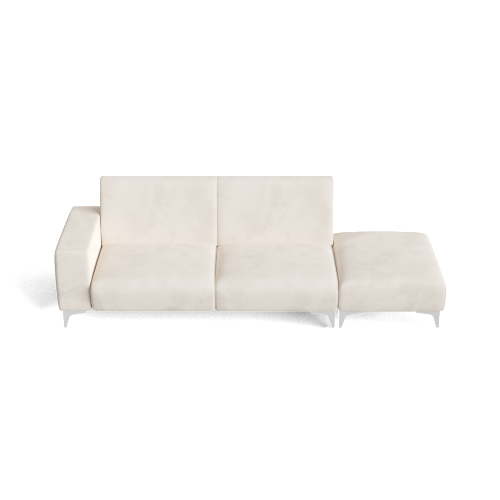

추천 아이템 Top14
추천 1순위 : 양면 시어서커 프릴 여름차렵이불 SS 이불베개세트 2colors (화이트)


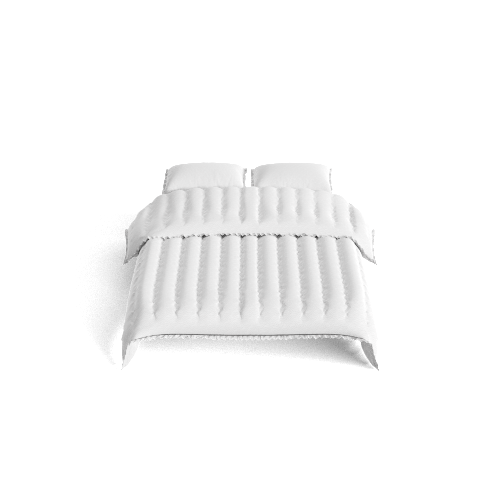

------------------------------------------------------------
추천 2순위 : 얼티마 하이브리드 스프링 매트리스 (SS) (화이트)


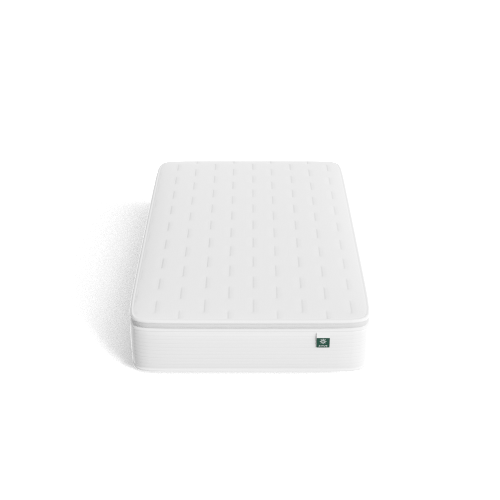

------------------------------------------------------------
추천 3순위 : 리모네 (50x70) (화이트)


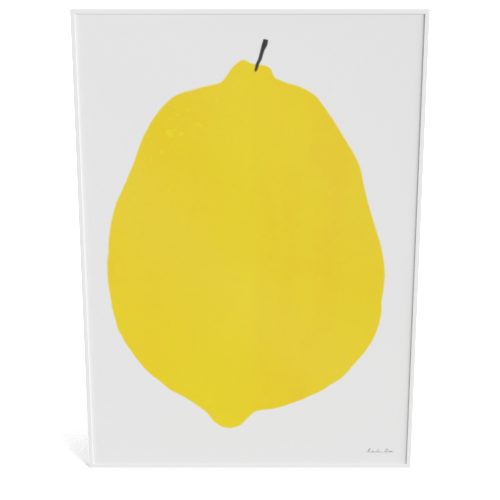

------------------------------------------------------------
추천 4순위 : 다용도 볼테이블 (볼3) (화이트)


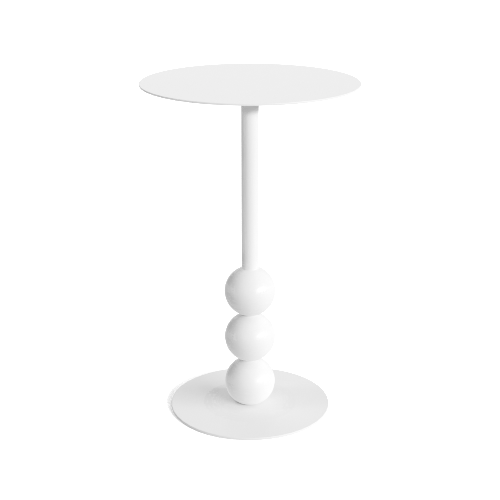

------------------------------------------------------------
추천 5순위 : 세타 네시노 단스탠드 (화이트)


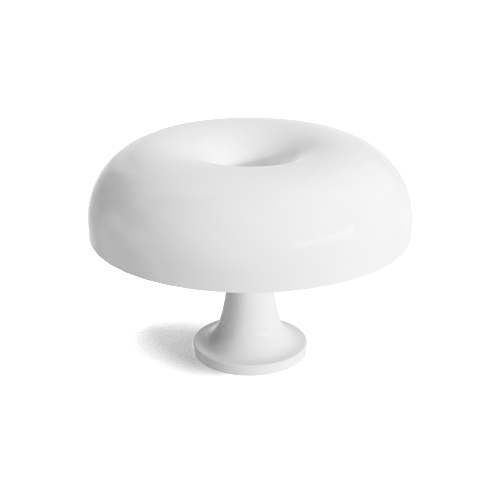

------------------------------------------------------------
추천 6순위 : 스테인레스 라운드 스툴 (실버)


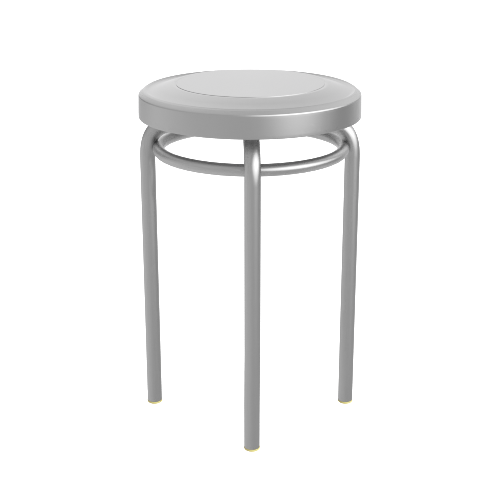

------------------------------------------------------------
추천 7순위 : SIMPLIE 협탁 BC021 (화이트)


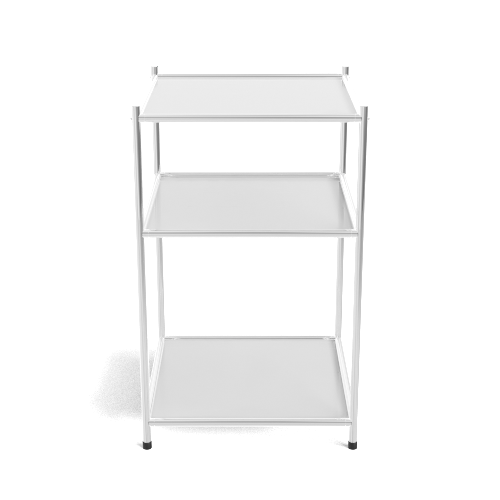

------------------------------------------------------------
추천 8순위 : OAK LEAVES


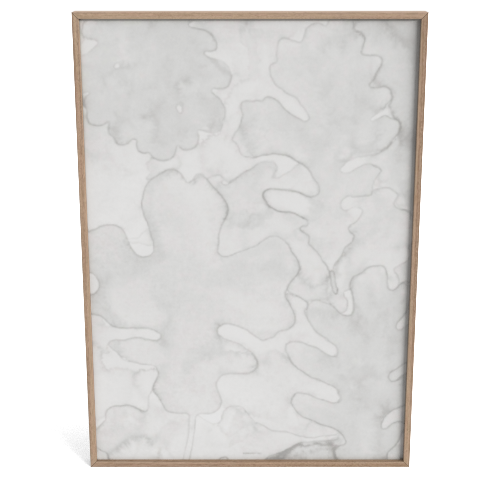

------------------------------------------------------------
추천 9순위 : 다용도 볼테이블 (볼3) (그레이)


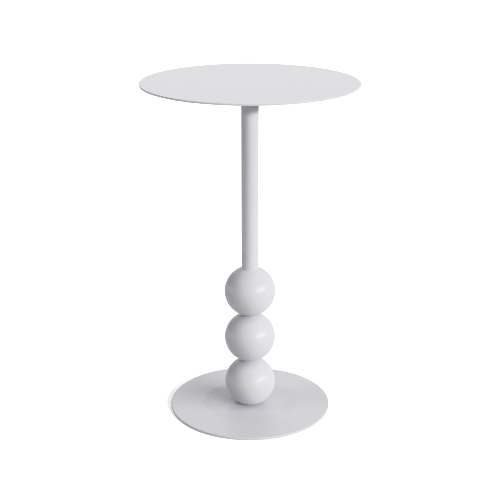

------------------------------------------------------------
추천 10순위 : 프로드 사하라 아쿠아텍스 4인용 리클라이너 카우치 소파 (아이보리)


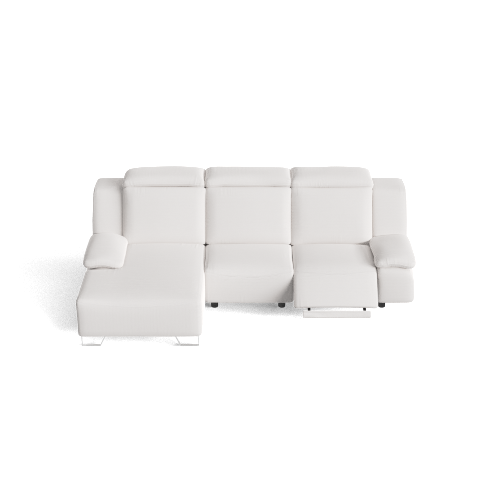

------------------------------------------------------------
추천 11순위 : 사계절 생활방수 워셔블 샤이 워터푸르프 러그카페트 스퀘어 2호 (아이보리)


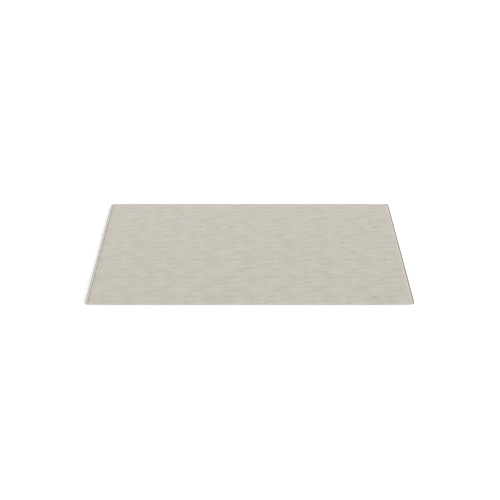

------------------------------------------------------------
추천 12순위 : 모노 1000 콘솔형 수납 화장대 (아이보리)


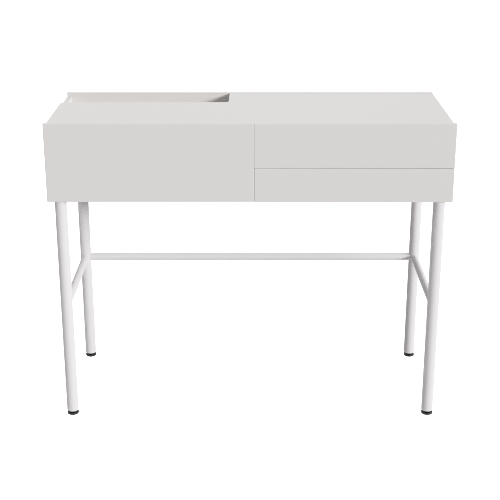

------------------------------------------------------------
추천 13순위 : 접이식 쿠션 등받이 의자 인테리어의자 (아이보리)


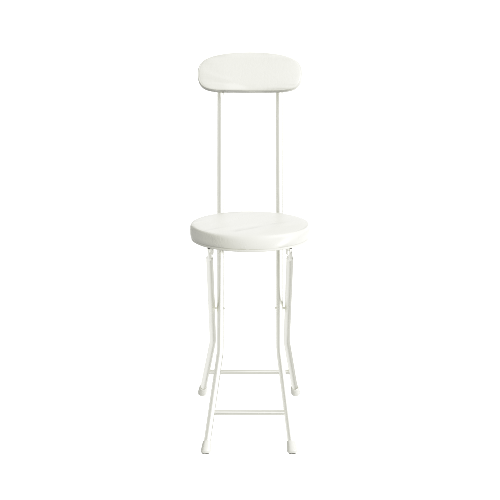

------------------------------------------------------------
추천 14순위 : 네온 팝 원형 러그 150cm (아이보리)


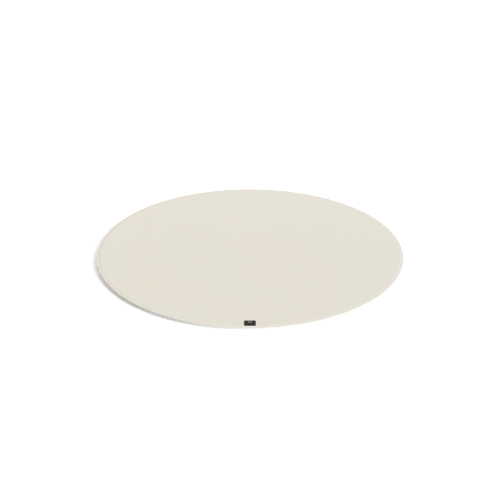

------------------------------------------------------------


In [1]:
import json
import pandas as pd
import numpy as np
from numpy import inf
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance
import time
import random
from glob import glob
from sklearn.metrics import classification_report, average_precision_score
from sklearn.model_selection import train_test_split
import os
from preprocess import Preprocess
from run import SEARCH_RECOMMEND
pd.set_option('mode.chained_assignment', None)


base_bath = '2022-03-14/'

# abs path -> 22-03-07/ *.json
best = glob(base_bath+'best*.json')
item = glob(base_bath+'item*.json')
products = glob(base_bath+'*products*.json')
#category1 == category2 = True
category = glob(base_bath+'categories.json')

DATA = Preprocess(best, item, products, category)

best_item_df, products_df_4, products_df_b = DATA.best_item, DATA.products_4, DATA.products_b

## 검색한 결과 show images
def show_result_and_image(df, prod, result_df, topn):
    # show result image
    print(f'사용자가 선택한 아이템 : {prod}')
    try:
        prod_res = requests.get(df[df['name'] == prod]['images'].values[0][0])
        display(Image.open(BytesIO(prod_res.content)))
    except:
        print('이미지 없음\n')
        print()

    print("="*80)
    print(f"추천 아이템 Top{topn}")
    print("="*80)

    i = 1
    for name, img_url in result_df[['name', 'images']].values:
        print(f"추천 {i}순위 : {name}")
        try:
            res = requests.get(img_url[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
        print("-"*60)
        i += 1
        
def run_search(ent_id, prod_name):
    """
    ent_id : 0 -> '421B6D0E746C4E6D', 1 -> 'B57D4F97C0E44A11'
    prod_name : 검색할 상품 이름
    """
    data = [products_df_4, products_df_b]
    topn = [10, 14]
    search_engine = SEARCH_RECOMMEND(data[ent_id], qval=None)
    rec_report = search_engine.search_product(prod_name, topn=topn[ent_id], algo='sorensen', 
                                             save_image=False, 
                                             verbose=False)
    
    rec_report_df = pd.DataFrame(rec_report, index=['사용자가 선택한 상품 ID', 
                                                '사용자가 선택한 상품',
                                                '사용자가 선택한 상품의 카테고리',
                                                '사용자가 선택한 상품이 해당한 Project Id', 
                                                '추천된 아이템', 
                                                '추천된 아이템 ID', 
                                                '추천된 아이템이 해당한 Project Id', 
                                                '사용자가 선택한 아이템-추천된 아이템 유사도']).T

    show_result_and_image(data[ent_id], prod_name, search_engine.result, topn[ent_id])
    
    return search_engine.result, search_engine.project_id
# enterpriseID = 0 -> 4 제품 , 1 -> B 제품
# prod = 검색하고 싶은 상품 이름입력

prod = "모아나 아쿠아텍스 3인용 소파(스툴포함) (아이보리)"
result, project_id = run_search(ent_id=1, prod_name=prod)

## 모델의 다양성 및 전문가 데이터 기반 평가지표

In [2]:
def average(result, project_id,products_df, number):
    results = []
    for i in range(len(project_id)):
        # products_df에서 검색한 프로젝트 아이디를 찾고 프로젝트 아이디가 가지고 있는 아이템들을 list로 가져오기
        project_products_id = products_df[products_df['projectId'] == project_id[i]]['product_id'].tolist()
        #result(추천해준 제품들) 리스트 업
        result_product_id = result['product_id'].tolist()
        for j in range(len(result_product_id)):
            # 해당 제품의 프로젝트 아이디가 가지고 있는 아이템 중 추천한 아이템이 들어있는가 
            if result_product_id[j] in project_products_id:
                # 들어있으면 1
                result_product_id[j] = 1
            else:
                # 없으면 0
                result_product_id[j] = 0
        results.append(result_product_id)

    total = []
    for res in results:
        total.append(sum(res) / len(res))
    
    total = sorted(total, reverse=True)[:5]
    print(f'Top {number} 해당해는 비율')
    for num, i in enumerate(total):
        print(f'Top {num+1}: 선택한 프로젝트 아이템이 들어있는 비율 : {round(i, 3)}  다른 프로젝트 아이템이 들어있는 비율 : {round(1 - i, 3)}')
        
    
# def sparse_matrix(products_df, result):
    # project 마다 item별 awesome_score 를 값으로 줘서 값이 존재하면 1 존재하지않으면 0
    if products_df['enterpriseId'].iloc[0] == 'B57D4F97C0E44A11':
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        print()
        # 예측 된 값과 추천 해준 값을 비교 
        print('전문가 셋 데이터 비교평가')
        
        print(classification_report(frame.iloc[0].values, train.values))
        
        ap = average_precision_score(frame.iloc[0].values, train.values)
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        
        frame.loc['전문가 아이템'] = train.values
    else:
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        print()
        # 예측 된 값과 추천 해준 값을 비교 
        print('전문가 셋 데이터 비교평가')
        # 예측 된 값과 추천 해준 값을 비교 
        print(classification_report(frame.iloc[0].values, train.values))
        
        ap = average_precision_score(frame.iloc[0].values, train.values)
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        # print( f'전문가   아이템 :{train.values}'),print(f'추천해준 아이템 :{frame.iloc[0].values}')
        frame.loc['전문가 아이템'] = train.values
    return frame, ap
result_frame, average_precision  = average(result, project_id, products_df_b, 5)

Top 5 해당해는 비율
Top 1: 선택한 프로젝트 아이템이 들어있는 비율 : 0.571  다른 프로젝트 아이템이 들어있는 비율 : 0.429
Top 2: 선택한 프로젝트 아이템이 들어있는 비율 : 0.357  다른 프로젝트 아이템이 들어있는 비율 : 0.643
Top 3: 선택한 프로젝트 아이템이 들어있는 비율 : 0.286  다른 프로젝트 아이템이 들어있는 비율 : 0.714
Top 4: 선택한 프로젝트 아이템이 들어있는 비율 : 0.214  다른 프로젝트 아이템이 들어있는 비율 : 0.786
Top 5: 선택한 프로젝트 아이템이 들어있는 비율 : 0.214  다른 프로젝트 아이템이 들어있는 비율 : 0.786

전문가 셋 데이터 비교평가
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.86      0.75      0.80         8

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.80      0.79      0.79        14

Average_Precision :  0.7857142857142856



In [3]:
result_frame

category,드레스룸/행거,반려동물,생활/운동,소파,수납가구,유아동가구,의자/스툴,조명,책상/테이블,책장/선반,침대/매트리스,패브릭,홈데코,화장대/거울
user,0,0,0,1,0,0,1,1,1,0,1,1,1,1
전문가 아이템,0,0,0,1,1,0,1,1,1,0,0,1,1,0
